# Computational Intelligence Methods in Data Analisys
### Task 5
##### Michał Tomczyk

During previous labs, we were supposed to create MLP Neural Network implementation from scratch. Our solution had to work both for classification and regression, use backpropagation, momentum and RMSProp. The objective of this task was to test different activation functions in MLP:

* sigmoid
* linear
* tanh
* ReLU

We were supposed to test the solution on multimodal-large set (regression) and then to choose 2 best performing functions and further analyse their results on 3 sets: steps-large (regression), rings5-regular and rings3-regular (classification).

During tests, all networks will use momentum and networks for classification problems will use softmax as the output activation function.

Loading data and necessary packages:

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error, f1_score
from matplotlib import pyplot as plt

In [3]:
df_1_train = pd.read_csv("./data/regression/multimodal-large-training.csv")
df_1_test = pd.read_csv("./data/regression/multimodal-large-test.csv")
df_2_train = pd.read_csv("./data/regression/steps-large-training.csv")
df_2_test = pd.read_csv("./data/regression/steps-large-test.csv")
df_3_train = pd.read_csv("./data/classification/rings3-regular-training.csv")
df_3_test = pd.read_csv("./data/classification/rings3-regular-test.csv")
df_4_train = pd.read_csv("./data/classification/rings5-regular-training.csv")
df_4_test = pd.read_csv("./data/classification/rings5-regular-test.csv")

Class for scaling and function for one-hot encoding:

In [3]:
class Scaler:
    def fit(self, X_train=None, y_train=None):
        if X_train is not None:
            self.meanx = X_train.mean()
            self.stdx = X_train.std()
        if y_train is not None:
            self.meany = y_train.mean()
            self.stdy = y_train.std()
    
    def scale(self, X=None, y=None):
        if X is None:
            return (y - self.meany)/self.stdy
        elif y is None:
            return (X - self.meanx)/self.stdx
        else:
            return (X - self.meanx)/self.stdx, (y - self.meany)/self.stdy
    
    def unscale(self, X=None, y=None):
        if y is None:
            return X * self.stdx + self.meanx
        elif X is None:
            return y * self.stdy + self.meany
        else:
            return X * self.stdx + self.meanx, y * self.stdy + self.meany

def encode(X):
        X = X.astype(int)
        res = np.zeros((X.size, X.max() + 1))
        res[np.arange(X.size), X.T] = 1
        return res


Classes of MLP Neural Networks - one for regression and one for classification, with all necessary methods:

In [4]:
class MLPRegressor:
    def __init__(self, neurons, function = "sigmoid"):
        self.act_function = function
        self.layers_num = len(neurons)
        self.neurons = neurons
        # He weight initialization for ReLU
        limits = [0 for i in range(len(neurons)-1)]
        if function == "relu":
            for i in range(len(neurons)-1):
                limits[i] = np.sqrt(2/neurons[i])
            self.weights = [np.random.randn(y,x) for x, y in zip(neurons[:-1], neurons[1:])]
            for i in range(len(self.weights)):
                self.weights[i] *= limits[i]
        else:
        # Xavier weight initialization for other activation functions
            for i in range(1,len(neurons)):
                limits[i-1] = np.sqrt(6)/np.sqrt(neurons[i-1]+neurons[i])
            self.weights = [np.random.uniform(0,1,(y, x)) for x, y in zip(neurons[:-1], neurons[1:])]
            for i in range(len(self.weights)):
                self.weights[i] = -limits[i] + self.weights[i]*(2*limits[i])
        self.biases = [np.zeros((y,1)) for y in neurons[1:]]
        
    def forward(self, x):
        a = x
        for i in range(len(self.weights)):
            a = np.dot(self.weights[i],a)+self.biases[i]
            if i != len(self.weights)-1:
                a = self.function(a)
        return a
            
    def backward(self, X, y):
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        a_last = X
        a = [X]
        z = []
        # feedforward with memorising z and a in each layer
        for i in range(len(self.weights)):
            z_last = np.dot(self.weights[i],a_last) + self.biases[i]
            z.append(z_last)
            if i!=len(self.weights)-1: 
                a_last = self.function(z_last)
            else:
                a_last = z_last
            a.append(a_last)
        #backward pass
        error = self.cost_derivative(a[-1], y)
        delta_b[-1] = error
        delta_w[-1] = np.dot(error, a[-2].transpose())
        for i in range(2,self.layers_num):
            z_last = z[-i]
            sd = self.function_derivative(z_last)
            error = np.dot(self.weights[-i+1].transpose(), error) * sd
            delta_b[-i] = error
            delta_w[-i] = np.dot(error, a[-i-1].transpose())
        return(delta_w, delta_b)
    
    def fit(self,X, y, learning_rate, epochs, batch_size = 256, lambda_momentum = None, beta = None):
        X = X[0]
        y = y[0]
        self.momentum_w = [np.zeros(w.shape) for w in self.weights]
        self.e_g_sq = [np.zeros(w.shape) for w in self.weights]
        costs = [0 for i in range(epochs)]
        for i in range(epochs):  
            X_batches = [X[k:k+batch_size] for k in range(0, len(X),batch_size)]
            y_batches = [y[k:k+batch_size] for k in range(0, len(y),batch_size)]
            for j in range(len(X_batches)):
                if lambda_momentum:
                    self.update_with_momentum(X_batches[j].reshape(1,len(X_batches[j])), y_batches[j].reshape(1,len(y_batches[j])), learning_rate, lambda_momentum)
                elif beta:
                    self.update_RMS(X_batches[j].reshape(1,len(X_batches[j])), y_batches[j].reshape(1,len(y_batches[j])), learning_rate, beta)
                else:
                    self.update(X_batches[j].reshape(1,len(X_batches[j])), y_batches[j].reshape(1,len(y_batches[j])), learning_rate)
            costs[i] = mean_squared_error(self.forward(X.reshape(1,len(X))),y.reshape(1,len(y)))

            if i%100 == 0:
                print(f"epoch {i+1} completed with cost: {costs[i]}")
        return costs
                                 
    def update(self, X, y, learning_rate):
        b1 = [np.zeros(b.shape) for b in self.biases]
        w1 = [np.zeros(w.shape) for w in self.weights]
        delta_w, delta_b = self.backward(X, y)
        b1 = [b+db for b, db in zip(b1,delta_b)]
        w1 = [w+dw for w, dw in zip(w1,delta_w)]
        self.weights = [w-(learning_rate)*dw for w, dw in zip(self.weights, w1)]
        self.biases = [b-np.dot(np.array((learning_rate)).repeat(len(X[0])),db.transpose()).reshape(np.shape(b)) for b, db in zip(self.biases, b1)]
        
    def update_with_momentum(self, X, y, learning_rate, lambda_moment):
        b1 = [np.zeros(b.shape) for b in self.biases]
        w1 = [np.zeros(w.shape) for w in self.weights]
        delta_w, delta_b = self.backward(X, y)
        b1 = [b+db for b, db in zip(b1,delta_b)]
        w1 = [w+dw for w, dw in zip(w1,delta_w)]
        self.momentum_w = [w + lambda_moment*m for w, m in zip(delta_w, self.momentum_w)]
        self.weights = [w-(learning_rate)*m for w, m in zip(self.weights, self.momentum_w)]
        self.biases = [b-np.dot(np.array((learning_rate)).repeat(len(X[0])),db.transpose()).reshape(np.shape(b)) for b, db in zip(self.biases, b1)]
        
    def update_RMS(self, X, y, learning_rate, beta):
        g_w = [np.zeros(w.shape) for w in self.weights]
        delta_w, delta_b = self.backward(X, y)
        g_w = [g + w for g,w in zip(g_w, delta_w)]
        self.e_g_sq = [beta*e_g + (1-beta)*(g**2) for e_g, g in zip(self.e_g_sq, g_w)]
        product = [g/(np.sqrt(e_g)) for g, e_g in zip(g_w, self.e_g_sq)]
        self.weights = [w - learning_rate*p for w, p in zip(self.weights, product)]
    
    def function(self,x):
        if self.act_function == "sigmoid":
            return self.sigmoid(x)
        elif self.act_function == "relu":
            return self.relu(x)
        elif self.act_function == "tanh":
            return np.tanh(x)
        elif self.act_function == "linear":
            return x
        raise Exception("Not a valid function name.")
        
    def function_derivative(self,x):
        if self.act_function == "sigmoid":
            return self.sigmoid_derivative(x)
        elif self.act_function == "relu":
            return self.relu_derivative(x)
        elif self.act_function == "tanh":
            return self.tanh_derivative(x)
        elif self.act_function == "linear":
            return self.linear_derivative(x)
        raise Exception("Not a valid function name.")
        
    def sigmoid(self, x):
        return 1.0/(1.0+np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def relu_derivative(self, x):
        return (x>0)*1
    
    def tanh_derivative(self, x):
        return 1-np.tanh(x)**2
    
    def linear_derivative(self, x):
        return(np.ones(np.shape(x)))
    
    def cost_derivative(self, y_pred, y):
        return(y_pred-y)

In [5]:
class MLPClassifier:
    def __init__(self, neurons, softmax = False, function = "sigmoid"):
        self.issoftmax = softmax
        self.act_function = function
        self.layers_num = len(neurons)
        self.neurons = neurons
        limits = [0 for i in range(len(neurons)-1)]
        # He wieght initialization for ReLU
        if function == "relu":
            for i in range(len(neurons)-1):
                limits[i] = np.sqrt(2/neurons[i])
            self.weights = [np.random.randn(x,y) for x, y in zip(neurons[:-1], neurons[1:])]
            for i in range(len(self.weights)):
                self.weights[i] *= limits[i]
        else:
        # Xavier weight initialization for other activation functions
            for i in range(1,len(neurons)):
                limits[i-1] = np.sqrt(6)/np.sqrt(neurons[i-1]+neurons[i])
            
            self.weights = [np.random.uniform(0,1,(x,y)) for x, y in zip(neurons[:-1], neurons[1:])]
            for i in range(len(self.weights)):
                self.weights[i] = -limits[i] + self.weights[i]*(2*limits[i])
        self.biases = [np.zeros(y) for y in neurons[1:]]
        
    def forward(self, x):
        a = x
        for i in range(len(self.weights)):
            a = np.dot(a,self.weights[i])+self.biases[i]
            if i != len(self.weights)-1:
                a = self.function(a)
            elif self.issoftmax:
                a = self.softmax(a)
        return a
    
    def fit(self,X, y, learning_rate, epochs, batch_size = 256, lambda_momentum = None, beta = None):
        p = np.random.permutation(len(X))
        X = X[p]
        y = y[p]
        self.momentum_w = [np.zeros(w.shape) for w in self.weights]
        self.e_g_sq = [np.zeros(w.shape) for w in self.weights]
        costs = [0 for i in range(epochs)]
        for i in range(epochs):  
            X_batches = [X[k:k+batch_size] for k in range(0, len(X),batch_size)]
            y_batches = [y[k:k+batch_size] for k in range(0, len(y),batch_size)]
            for j in range(len(X_batches)):
                if lambda_momentum:
                    self.update_with_momentum(X_batches[j].reshape(len(X_batches[j]),self.neurons[0]), y_batches[j].reshape(len(y_batches[j]),self.neurons[-1]), learning_rate, lambda_momentum)
                elif beta:
                    self.update_RMS(X_batches[j].reshape(len(X_batches[j]),self.neurons[0]), y_batches[j].reshape(len(y_batches[j]),self.neurons[-1]), learning_rate, beta)
                else:
                    self.update(X_batches[j].reshape(len(X_batches[j]),self.neurons[0]), y_batches[j].reshape(len(y_batches[j]),self.neurons[-1]), learning_rate)
            y_pred = self.forward(X.reshape(len(X),self.neurons[0]))
            costs[i] = f1_score(np.argmax(y_pred, axis=1),np.argmax(y.reshape(len(y),self.neurons[-1]),axis=1),average='macro')
            if i%100 == 0:
                print(f"epoch {i+1} completed, cost: {costs[i]}")
        return costs
            
    def backward(self, X, y):
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        a_last = X
        a = [X]
        z = []
        # feedforward with memorising z and a in each layer
        for i in range(len(self.weights)):
            z_last = np.einsum('ij, jk -> ik', a_last,self.weights[i]) + self.biases[i]
            z.append(z_last)
            if i!=len(self.weights)-1: 
                a_last = self.function(z_last)
            elif self.softmax:
                a_last = self.softmax(z_last)
            else:
                a_last = z_last
            a.append(a_last)
        #backward pass
        if self.issoftmax:
            error = self.cost_derivative(a[-1], y)*self.softmax_derivative(z[-1])
        else:
            error = self.cost_derivative(a[-1], y)
        delta_b[-1] = -error.sum(axis=0)
        delta_w[-1] = -np.einsum('ji,jk->ik', a[-2], error)
        for i in range(2,self.layers_num):
            e_last = error
            error = self.function_derivative(z[-i]) * np.einsum('ij,jk->ik', e_last, self.weights[-i+1].transpose())
            delta_w[-i] = -np.einsum('ji,jk->ik', a[-i-1],error)
            delta_b[-i] = -error.sum(axis=0)
        return(delta_w, delta_b)
    
                                 
    def update(self, X, y, learning_rate):
        delta_w, delta_b = self.backward(X, y)
        self.weights = [w + learning_rate*dw for w,dw in zip(self.weights, delta_w)]
        self.biases = [b + learning_rate*db for b,db in zip(self.biases, delta_b)]
        
    def update_with_momentum(self, X, y, learning_rate, lambda_moment):
        delta_w, delta_b = self.backward(X, y)
        self.momentum_w = [w + lambda_moment*m for w, m in zip(delta_w, self.momentum_w)]
        self.weights = [w+learning_rate*m for w, m in zip(self.weights, self.momentum_w)]
        self.biases = [b+learning_rate*db for b, db in zip(self.biases, delta_b)]
        
    def update_RMS(self, X, y, learning_rate, beta):
        g_w = [np.zeros(w.shape) for w in self.weights]
        delta_w, delta_b = self.backward(X, y)
        g_w = [g + w for g,w in zip(g_w, delta_w)]
        self.e_g_sq = [beta*e_g + (1-beta)*(g**2) for e_g, g in zip(self.e_g_sq, g_w)]
        product = [g/(np.sqrt(e_g)) for g, e_g in zip(g_w, self.e_g_sq)]
        self.weights = [w + learning_rate*p for w, p in zip(self.weights, product)]
        self.biases = [b+learning_rate*db for b, db in zip(self.biases, delta_b)]
        
    def function(self,x):
        if self.act_function == "sigmoid":
            return self.sigmoid(x)
        elif self.act_function == "relu":
            return self.relu(x)
        elif self.act_function == "tanh":
            return np.tanh(x)
        elif self.act_function == "linear":
            return x
        raise Exception("Not a valid function name.")
        
    def function_derivative(self,x):
        if self.act_function == "sigmoid":
            return self.sigmoid_derivative(x)
        elif self.act_function == "relu":
            return self.relu_derivative(x)
        elif self.act_function == "tanh":
            return self.tanh_derivative(x)
        elif self.act_function == "linear":
            return self.linear_derivative(x)
        raise Exception("Not a valid function name.")
        
    def sigmoid(self, x):
        return 1.0/(1.0+np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def relu(self, x):
        return np.maximum(x, 0)
    
    def relu_derivative(self, x):
        return (x>0)*1
    
    def tanh_derivative(self, x):
        return 1-np.tanh(x)**2
    
    def linear_derivative(self, x):
        return(np.ones(np.shape(x)))
    
    def cost_derivative(self, y_pred, y):
        return(y_pred-y)
    
    def softmax(self, x):
        return np.exp(x) / np.exp(x).sum(axis=1).reshape(-1, 1)
    
    def softmax_derivative(self, x):
        return self.softmax(x)*(1-self.softmax(x))
    
    def cross_entropy(self, y_pred, y):
        return -np.log((y * y_pred).sum(axis=1)).mean()
    
    def cost_derivative(self, y_pred, y):
        return(y_pred-y)

In [6]:
np.random.seed(11)

### multimodal-large

All four activation functions needed to be tested on multimodal-large dataset.

In [7]:
X_train, y_train = np.array(df_1_train.x).reshape(1,10000), np.array(df_1_train.y).reshape(1,10000)
X_test, y_test = np.array(df_1_test.x).reshape(1,1000), np.array(df_1_test.y).reshape(1,1000)

scaler_x = Scaler()
scaler_x.fit(X_train)
X_train, X_test = scaler_x.scale(X_train), scaler_x.scale(X_test)

scaler_y = Scaler()
scaler_y.fit(y_train)
y_train, y_test = scaler_y.scale(y_train), scaler_y.scale(y_test)

##### sigmoid

In [8]:
mlp_sigmoid = MLPRegressor([1,10,10,10,1], "sigmoid")
costs_sigmoid = mlp_sigmoid.fit(X_train, y_train, 0.001, 1500, 256, lambda_momentum = 0.9)

epoch 1 completed with cost: 0.9128707376527824
epoch 101 completed with cost: 0.08117863023106675
epoch 201 completed with cost: 0.07564236972232923
epoch 301 completed with cost: 0.05753695668608303
epoch 401 completed with cost: 0.047257357594105896
epoch 501 completed with cost: 0.099158088901833
epoch 601 completed with cost: 0.08131776538031896
epoch 701 completed with cost: 0.0025164575009227275
epoch 801 completed with cost: 0.0019528501706886346
epoch 901 completed with cost: 0.0018224623994479885
epoch 1001 completed with cost: 0.0017384277716538214
epoch 1101 completed with cost: 0.0016677052226813053
epoch 1201 completed with cost: 0.0016226719358107772
epoch 1301 completed with cost: 0.0015916969305628127
epoch 1401 completed with cost: 0.001568210405578416


In [9]:
y_sigmoid = mlp_sigmoid.forward(X_test)
y_sigmoid_unscaled = scaler_y.unscale(y_sigmoid)
y_test_unscaled = scaler_y.unscale(y_test)
print(mean_squared_error(y_sigmoid_unscaled, y_test_unscaled))

4.016213419257126


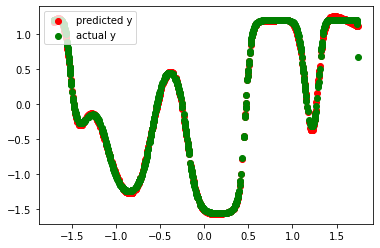

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_test, y_sigmoid, c="r", label="predicted y")
ax.scatter(X_test, y_test, c="g", label="actual y")
plt.legend(loc = "upper left")
plt.show()

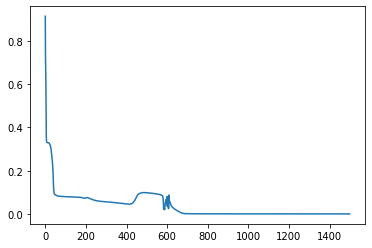

In [11]:
plt.plot(costs_sigmoid)

##### ReLu

In [15]:
mlp_relu = MLPRegressor([1,10,10,10,1], "relu")
costs_relu = mlp_relu.fit(X_train, y_train, 0.0001, 1500, 256, lambda_momentum = 0.9)

epoch 1 completed with cost: 0.6255789842469028
epoch 101 completed with cost: 0.04183814024257936
epoch 201 completed with cost: 0.03470953281341205
epoch 301 completed with cost: 0.03061272814605886
epoch 401 completed with cost: 0.029116421269437278
epoch 501 completed with cost: 0.028441729271986748
epoch 601 completed with cost: 0.028005362243370517
epoch 701 completed with cost: 0.011944906400538797
epoch 801 completed with cost: 0.0070250516258837095
epoch 901 completed with cost: 0.006842443170851085
epoch 1001 completed with cost: 0.006759923555217784
epoch 1101 completed with cost: 0.006698598910532772
epoch 1201 completed with cost: 0.0066782097819708015
epoch 1301 completed with cost: 0.006627180299402875
epoch 1401 completed with cost: 0.006541393052747556


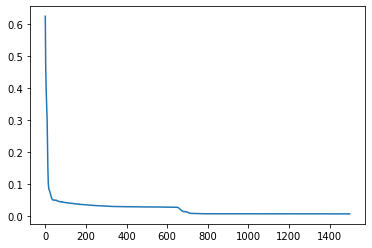

In [16]:
plt.plot(costs_relu)

In [17]:
y_relu = mlp_relu.forward(X_test)
y_relu_unscaled = scaler_y.unscale(y_relu)
print(mean_squared_error(y_relu_unscaled, y_test_unscaled))

31.34345930473693


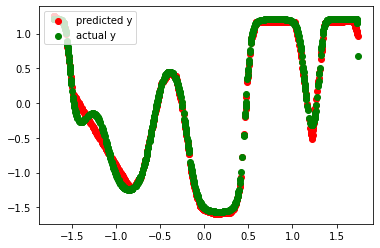

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_test, y_relu, c="r", label="predicted y")
ax.scatter(X_test, y_test, c="g", label="actual y")
plt.legend(loc = "upper left")
plt.show()

##### tanh

In [19]:
mlp_tanh = MLPRegressor([1,10,10,10,1], "tanh")
costs_tanh = mlp_tanh.fit(X_train, y_train, 0.0003, 1500, 256, lambda_momentum = 0.9)

epoch 1 completed with cost: 0.45613247772880716
epoch 101 completed with cost: 0.005825637625718424
epoch 201 completed with cost: 0.001526501373543832
epoch 301 completed with cost: 0.0013469060148508297
epoch 401 completed with cost: 0.0012519170619341039
epoch 501 completed with cost: 0.0012172493825729908
epoch 601 completed with cost: 0.0012015488583012224
epoch 701 completed with cost: 0.0011911030096200547
epoch 801 completed with cost: 0.0011825217984751776
epoch 901 completed with cost: 0.0011749111094746395
epoch 1001 completed with cost: 0.0011679805928215678
epoch 1101 completed with cost: 0.0011616020223492284
epoch 1201 completed with cost: 0.001155680995627741
epoch 1301 completed with cost: 0.0011501126684953916
epoch 1401 completed with cost: 0.0011447717131240597


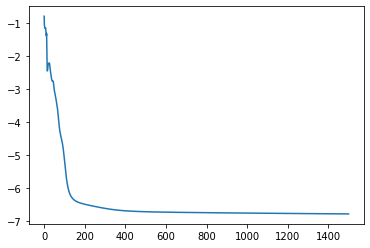

In [20]:
plt.plot(np.log(costs_tanh))

In [21]:
y_tanh = mlp_tanh.forward(X_test)
y_tanh_unscaled = scaler_y.unscale(y_tanh)
print(mean_squared_error(y_tanh_unscaled, y_test_unscaled))

1.901904763913899


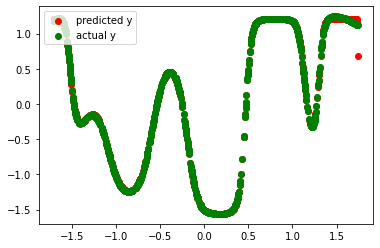

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_test, y_test, c="r", label="predicted y")
ax.scatter(X_test, y_tanh, c="g", label="actual y")
plt.legend(loc = "upper left")
plt.show()

##### funkcja liniowa

In [24]:
mlp_linear = MLPRegressor([1,10,10,10,1], "linear")
costs_linear = mlp_linear.fit(X_train, y_train, 0.001, 1500, 256, lambda_momentum = 0.9)

epoch 1 completed with cost: 0.8651105232229759
epoch 101 completed with cost: 0.8495258527850561
epoch 201 completed with cost: 0.8495259201332325
epoch 301 completed with cost: 0.8495259625924271
epoch 401 completed with cost: 0.8495259901650315
epoch 501 completed with cost: 0.8495260084778286
epoch 601 completed with cost: 0.8495260209445789
epoch 701 completed with cost: 0.8495260296572984
epoch 801 completed with cost: 0.8495260359115102
epoch 901 completed with cost: 0.8495260405192246
epoch 1001 completed with cost: 0.8495260439967175
epoch 1101 completed with cost: 0.8495260466778686
epoch 1201 completed with cost: 0.8495260487829491
epoch 1301 completed with cost: 0.8495260504606172
epoch 1401 completed with cost: 0.8495260518137245


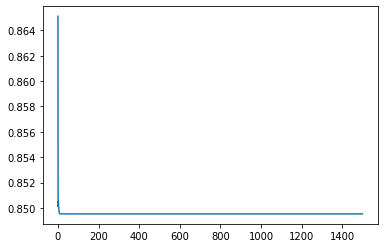

In [25]:
plt.plot(costs_linear)

In [26]:
y_linear = mlp_linear.forward(X_test)
y_linear_unscaled = scaler_y.unscale(y_linear)
print(mean_squared_error(y_linear_unscaled, y_test_unscaled))

4433.723828217717


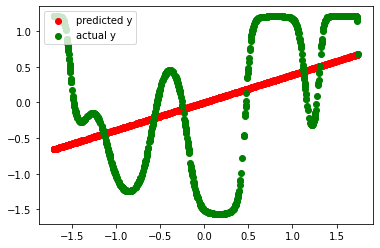

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_test, y_linear, c="r", label="predicted y")
ax.scatter(X_test, y_test, c="g", label="actual y")
plt.legend(loc = "upper left")
plt.show()

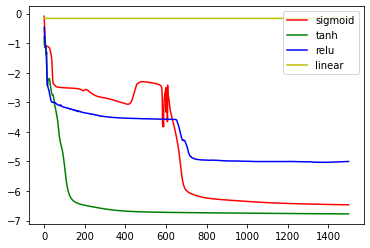

In [28]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.log(costs_sigmoid), c="r", label="sigmoid")
ax.plot(np.log(costs_tanh), c="g", label="tanh")
ax.plot(np.log(costs_relu), c="b", label="relu")
ax.plot(np.log(costs_linear), c="y", label="linear")
plt.legend(loc = "upper right")
plt.show()

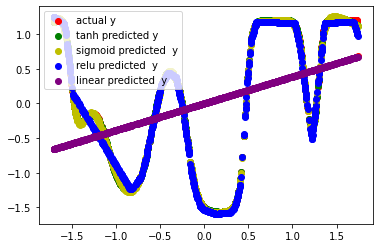

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_test, y_test, c="r", label="actual y")
ax.scatter(X_test, y_tanh, c="g", label="tanh predicted y")
ax.scatter(X_test, y_sigmoid, c="y", label="sigmoid predicted  y")
ax.scatter(X_test, y_relu, c="b", label="relu predicted  y")
ax.scatter(X_test, y_linear, c="purple", label="linear predicted  y")
plt.legend(loc = "upper left")plt.show()

As we can see, the worst performance is given by linear function. It makes sense, as the combination of linear functions will always be a linear function, thus a better fit is not possible. Best results are achieved by tanh function. Initially ReLU was learning quicker than sigmoid, but nearly stopped learning at some point. Moreover, the preformance of this function is higly dependent on architecture of a network (ReLU won't work on bad network architecture, where other functions will just learn slower / produce different results). It also needs to be noted that ReLU and tanh require a smaller learning rate.

### steps-large

For further analysis let's focus on sigmoid and tanh functions, as they produced the best results.

In [30]:
X_train, y_train = np.array(df_2_train.x).reshape(1,10000), np.array(df_2_train.y).reshape(1,10000)
X_test, y_test = np.array(df_2_test.x).reshape(1,1000), np.array(df_2_test.y).reshape(1,1000)

scaler_x = Scaler()
scaler_x.fit(X_train)
X_train, X_test = scaler_x.scale(X_train), scaler_x.scale(X_test)

scaler_y = Scaler()
scaler_y.fit(y_train)
y_train, y_test = scaler_y.scale(y_train), scaler_y.scale(y_test)

##### sigmoid

In [32]:
mlp_sigmoid = MLPRegressor([1,5,5,5,1], "sigmoid")
costs_sigmoid = mlp_sigmoid.fit(X_train, y_train, 0.01, 1500, 32, lambda_momentum = 0.9)

epoch 1 completed with cost: 0.07933633648747059
epoch 101 completed with cost: 0.005793006540807276
epoch 201 completed with cost: 0.004241002740986751
epoch 301 completed with cost: 0.00410193880398481
epoch 401 completed with cost: 0.003862326309423915
epoch 501 completed with cost: 0.0035708304886471792
epoch 601 completed with cost: 0.0032988175483409485
epoch 701 completed with cost: 0.00313970165670274
epoch 801 completed with cost: 0.0030542092821720986
epoch 901 completed with cost: 0.002964128811314152
epoch 1001 completed with cost: 0.0028180568541312572
epoch 1101 completed with cost: 0.002664961223434309
epoch 1201 completed with cost: 0.002535123276402628
epoch 1301 completed with cost: 0.002423951016317268
epoch 1401 completed with cost: 0.002321505721450057


In [33]:
y_sigmoid = mlp_sigmoid.forward(X_test)
y_sigmoid_unscaled = scaler_y.unscale(y_sigmoid)
y_test_unscaled = scaler_y.unscale(y_test)
print(mean_squared_error(y_sigmoid_unscaled, y_test_unscaled))

7.11834392045612


##### tanh

In [37]:
mlp_tanh = MLPRegressor([1,5,5,5,1], "tanh")
costs_tanh = mlp_tanh.fit(X_train, y_train, 0.002, 1500, 32, lambda_momentum = 0.8)

epoch 1 completed with cost: 0.07435320590382141
epoch 101 completed with cost: 0.005072115116971165
epoch 201 completed with cost: 0.003077754869400218
epoch 301 completed with cost: 0.002697300912209307
epoch 401 completed with cost: 0.0024018815368184476
epoch 501 completed with cost: 0.0021801192765101072
epoch 601 completed with cost: 0.0020431000969064
epoch 701 completed with cost: 0.0019454747689114811
epoch 801 completed with cost: 0.0018682939991127522
epoch 901 completed with cost: 0.001783785426657419
epoch 1001 completed with cost: 0.0016774967770538216
epoch 1101 completed with cost: 0.0015857962132119797
epoch 1201 completed with cost: 0.0015192216099399766
epoch 1301 completed with cost: 0.001475226447946558
epoch 1401 completed with cost: 0.001443837719092958


In [38]:
y_tanh = mlp_tanh.forward(X_test)
y_tanh_unscaled = scaler_y.unscale(y_tanh)
y_test_unscaled = scaler_y.unscale(y_test)
print(mean_squared_error(y_tanh_unscaled, y_test_unscaled))

5.632803998083536


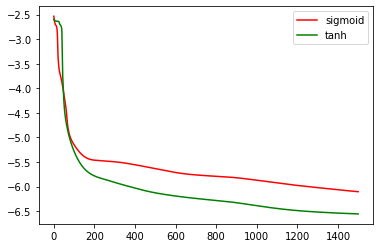

In [42]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.log(costs_sigmoid), c="r", label="sigmoid")
ax.plot(np.log(costs_tanh), c="g", label="tanh")
plt.legend(loc = "upper right")
plt.show()

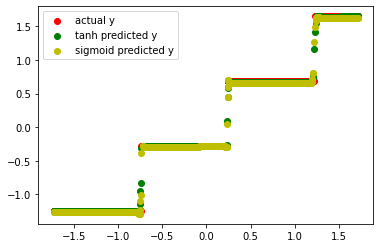

In [40]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_test, y_test, c="r", label="actual y")
ax.scatter(X_test, y_tanh, c="g", label="tanh predicted y")
ax.scatter(X_test, y_sigmoid, c="y", label="sigmoid predicted y")
plt.legend(loc = "upper left")
plt.show()

As we can see, tanh performed better in the case of this dataset.

### rings-3

In [43]:
X_train, y_train = np.array([df_3_train.x, df_3_train.y]).transpose(), np.array([df_3_train.c]).transpose()
X_test, y_test = np.array([df_3_test.x, df_3_test.y]).transpose(), np.array([df_3_test.c]).transpose()
scaler = Scaler()
scaler.fit(X_train)

X_train = scaler.scale(X_train)
X_test = scaler.scale(X_test)
y_train_enc = encode(y_train)
y_test_enc = encode(y_test)

##### sigmoid

In [44]:
mlp_sigmoid = MLPClassifier([2,15,15,3],True,  "sigmoid")
costs_sigmoid = mlp_sigmoid.fit(X_train, y_train_enc, 0.008, 2000, 32, lambda_momentum = 0.7)

epoch 1 completed, cost: 0.34191364717930184
epoch 101 completed, cost: 0.6552993128303702
epoch 201 completed, cost: 0.7730258666914351
epoch 301 completed, cost: 0.8109567319425999
epoch 401 completed, cost: 0.8896296740845427
epoch 501 completed, cost: 0.9269218238469974
epoch 601 completed, cost: 0.9423536009789896
epoch 701 completed, cost: 0.9476916036054788
epoch 801 completed, cost: 0.9510263954998628
epoch 901 completed, cost: 0.9537483796091424
epoch 1001 completed, cost: 0.9578339694849497
epoch 1101 completed, cost: 0.9612369337979093
epoch 1201 completed, cost: 0.9632411084809741
epoch 1301 completed, cost: 0.9638615979970561
epoch 1401 completed, cost: 0.9651707639241733
epoch 1501 completed, cost: 0.9665199668229502
epoch 1601 completed, cost: 0.9672151326222741
epoch 1701 completed, cost: 0.9732892261977403
epoch 1801 completed, cost: 0.9753230472533341
epoch 1901 completed, cost: 0.9739743701746472


In [45]:
y_sigmoid = mlp_sigmoid.forward(X_test)
y_sigmoid = np.argmax(y_sigmoid, axis=1).reshape(-1,1)

In [46]:
f1_score(y_sigmoid, df_3_test.c,average='macro')

0.9617618839479167

##### tanh

In [47]:
mlp_tanh = MLPClassifier([2,15,15,3],True, "tanh")
costs_tanh = mlp_tanh.fit(X_train, y_train_enc, 0.004, 2000, 32, lambda_momentum = 0.7)

epoch 1 completed, cost: 0.46559399796687934
epoch 101 completed, cost: 0.9606914644505831
epoch 201 completed, cost: 0.9766391423553099
epoch 301 completed, cost: 0.9766330714431909
epoch 401 completed, cost: 0.9772990721091915
epoch 501 completed, cost: 0.9779878482063729
epoch 601 completed, cost: 0.9813264382286739
epoch 701 completed, cost: 0.979314235030967
epoch 801 completed, cost: 0.9786417472321037
epoch 901 completed, cost: 0.9833208782868667
epoch 1001 completed, cost: 0.9806391694445825
epoch 1101 completed, cost: 0.9846528973034997
epoch 1201 completed, cost: 0.9839858747698725
epoch 1301 completed, cost: 0.9839858747698725
epoch 1401 completed, cost: 0.9846511236507146
epoch 1501 completed, cost: 0.9853193359536959
epoch 1601 completed, cost: 0.9879894672821452
epoch 1701 completed, cost: 0.9873189556966168
epoch 1801 completed, cost: 0.9879894672821452
epoch 1901 completed, cost: 0.9879926366065049


In [48]:
y_tanh = mlp_tanh.forward(X_test)
y_tanh = np.argmax(y_tanh, axis=1).reshape(-1,1)

In [49]:
f1_score(y_tanh, df_3_test.c,average='macro')

0.9640536506251115

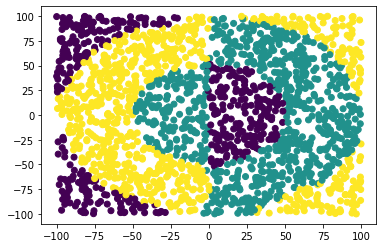

In [50]:
plt.scatter(df_3_test.x, df_3_test.y, c=y_tanh)

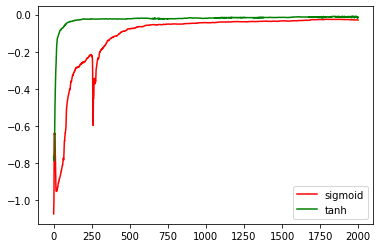

In [51]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.log(costs_sigmoid), c="r", label="sigmoid")
ax.plot(np.log(costs_tanh), c="g", label="tanh")
plt.legend(loc = "lower right")
plt.show()

After a large number of iterations, both functions start to produce similar results, but tanh performs slightly better. This function also starts to achieve satisfactory results much quicker.

### rings-5

In [52]:
X_train, y_train = np.array([df_4_train.x, df_4_train.y]).transpose(), np.array([df_4_train.c]).transpose()
X_test, y_test = np.array([df_4_test.x, df_4_test.y]).transpose(), np.array([df_4_test.c]).transpose()
scaler = Scaler()
scaler.fit(X_train)

X_train = scaler.scale(X_train)
X_test = scaler.scale(X_test)
y_train_enc = encode(y_train)
y_test_enc = encode(y_test)

##### sigmoid

In [59]:
mlp_sigmoid = MLPClassifier([2,20,20,20,5], True, "sigmoid")
costs_sigmoid = mlp_sigmoid.fit(X_train, y_train_enc, 0.01, 2500, 32, lambda_momentum = 0.7)

epoch 1 completed, cost: 0.09525936412669611
epoch 101 completed, cost: 0.343921743583172
epoch 201 completed, cost: 0.6497200816343068
epoch 301 completed, cost: 0.6702800055607295
epoch 401 completed, cost: 0.6657591494033019
epoch 501 completed, cost: 0.664251916337536
epoch 601 completed, cost: 0.7395919072084232
epoch 701 completed, cost: 0.8399156768735117
epoch 801 completed, cost: 0.8943237516483917
epoch 901 completed, cost: 0.9051132743566423
epoch 1001 completed, cost: 0.9256958193351256
epoch 1101 completed, cost: 0.9351232319475311
epoch 1201 completed, cost: 0.9375121383259186
epoch 1301 completed, cost: 0.9407162791993425
epoch 1401 completed, cost: 0.937472412460093
epoch 1501 completed, cost: 0.9375292745266591
epoch 1601 completed, cost: 0.9391486019067419
epoch 1701 completed, cost: 0.9422413768249317
epoch 1801 completed, cost: 0.940590576542767
epoch 1901 completed, cost: 0.9470563476330435
epoch 2001 completed, cost: 0.9590581249734814
epoch 2101 completed, cost: 

In [60]:
y_sigmoid = mlp_sigmoid.forward(X_test)
y_sigmoid = np.argmax(y_sigmoid, axis=1).reshape(-1,1)

In [61]:
f1_score(y_sigmoid, df_4_test.c,average='macro')

0.933559678578526

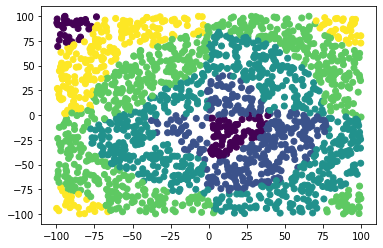

In [62]:
plt.scatter(df_4_test.x, df_4_test.y, c=y_sigmoid)

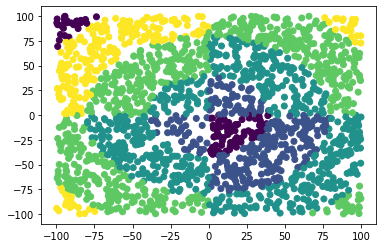

In [63]:
plt.scatter(df_4_test.x, df_4_test.y, c=df_4_test.c)

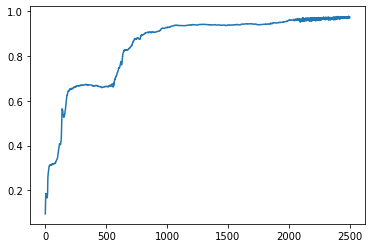

In [64]:
plt.plot(costs_sigmoid)

##### tanh

In [66]:
mlp_tanh = MLPClassifier([2,20,20,20,5], True, "tanh")
costs_tanh = mlp_tanh.fit(X_train, y_train_enc, 0.005, 2500, 32, lambda_momentum = 0.7)

epoch 1 completed, cost: 0.22612064260695403
epoch 101 completed, cost: 0.9145847098475869
epoch 201 completed, cost: 0.9526044701706073
epoch 301 completed, cost: 0.9655308047497044
epoch 401 completed, cost: 0.9654573746632515
epoch 501 completed, cost: 0.970346833834828
epoch 601 completed, cost: 0.9503884549765971
epoch 701 completed, cost: 0.9760108730987334
epoch 801 completed, cost: 0.9808102730287779
epoch 901 completed, cost: 0.9665034830244915
epoch 1001 completed, cost: 0.9769199803459927
epoch 1101 completed, cost: 0.977653555034698
epoch 1201 completed, cost: 0.9744155264331706
epoch 1301 completed, cost: 0.9848047103031787
epoch 1401 completed, cost: 0.9880076234510909
epoch 1501 completed, cost: 0.9800399455201877
epoch 1601 completed, cost: 0.9887989675640683
epoch 1701 completed, cost: 0.9872004869037037
epoch 1801 completed, cost: 0.9872181819736994
epoch 1901 completed, cost: 0.9776334754674464
epoch 2001 completed, cost: 0.9832025267233139
epoch 2101 completed, cost

In [67]:
y_tanh = mlp_tanh.forward(X_test)
y_tanh = np.argmax(y_tanh, axis=1).reshape(-1,1)

In [68]:
f1_score(y_tanh, df_4_test.c,average='macro')

0.9553613289593132

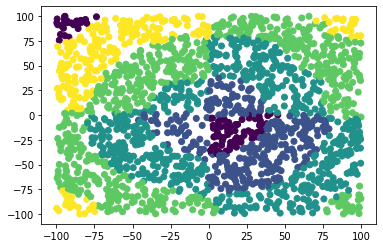

In [69]:
plt.scatter(df_4_test.x, df_4_test.y, c=y_tanh)

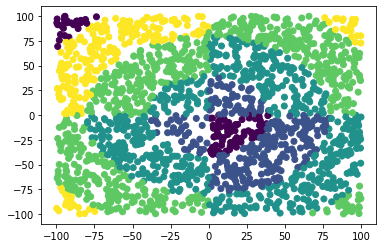

In [70]:
plt.scatter(df_4_test.x, df_4_test.y, c=df_4_test.c)

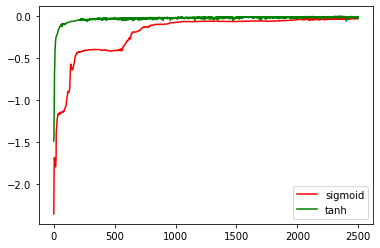

In [71]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.log(costs_sigmoid), c="r", label="sigmoid")
ax.plot(np.log(costs_tanh), c="g", label="tanh")
plt.legend(loc = "lower right")
plt.show()

Just like in previous case, tanh performs better and converges quicker.

### Conclusion
Hyperbolic tangent activity function performed best in tests. Sigmoid function produced slightly worse results. ReLU function worked worse than ones above, but its cost function converged quicker in the beggining. Linear function was the one with the wortst performance. It needs to be remembered that tanh and ReLU require a smaller learning rate and that ReLU will not produce satisfactory results when the number of layers and neurons in each layer is chosen wrong. It also requires a different weight initialization method (He) than the rest (Xavier).